Found 4787 images belonging to 3 classes.
Found 1195 images belonging to 3 classes.
Epoch 1/3
75/75 [==============================] - 79s 1s/step - loss: 0.2789 - binary_accuracy: 0.8949 - val_loss: 0.1818 - val_binary_accuracy: 0.9303
Epoch 2/3
75/75 [==============================] - 78s 1s/step - loss: 0.1251 - binary_accuracy: 0.9531 - val_loss: 0.1715 - val_binary_accuracy: 0.9364
Epoch 3/3
75/75 [==============================] - 78s 1s/step - loss: 0.1022 - binary_accuracy: 0.9612 - val_loss: 0.1413 - val_binary_accuracy: 0.9470
Epoch 1/3
75/75 [==============================] - 92s 1s/step - loss: 0.1010 - binary_accuracy: 0.9640 - val_loss: 0.1333 - val_binary_accuracy: 0.9487
Epoch 2/3
75/75 [==============================] - 120s 2s/step - loss: 0.0891 - binary_accuracy: 0.9669 - val_loss: 0.1316 - val_binary_accuracy: 0.9517
Epoch 3/3
19/19 [==============================] - 17s 908ms/step - loss: 0.1256 - binary_accuracy: 0.9509
Validation accuracy: 95.09%


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


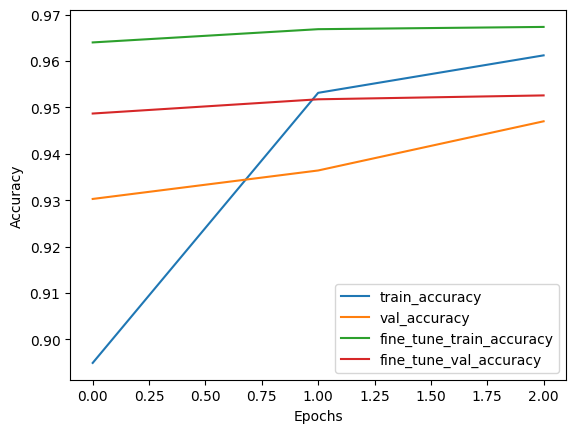

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

img_size = 128  
batch_size = 64
data_dir = 'Data'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='sigmoid')  
])

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),  
    metrics=[BinaryAccuracy()] )

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3, 
    callbacks=[early_stopping]
)

for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5), 
    loss=BinaryCrossentropy(), 
    metrics=[BinaryAccuracy()]
)

history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3, 
    callbacks=[early_stopping]
)

loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy*100:.2f}%')

model.save('multi_label_dental_disease_model_mobilenetv2.h5')


plt.plot(history.history['binary_accuracy'], label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
plt.plot(history_fine_tune.history['binary_accuracy'], label='fine_tune_train_accuracy')
plt.plot(history_fine_tune.history['val_binary_accuracy'], label='fine_tune_val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
